!pip install open3d
!pip install --upgrade pygments

In [1]:
import open3d as o3d
import numpy as np
import copy
# 定义文件路径
cube_obj_path = "mesh/cube_0.obj"
zed_ply_path = "mesh/zed_point_cloud_world3.ply"

# 读取 cube_0.obj 点云
cube_mesh = o3d.io.read_triangle_mesh(cube_obj_path)
cube_mesh.compute_vertex_normals()  # 计算法线以便更好显示

# 读取 zed_point_cloud_world.ply 点云
zed_point_cloud = o3d.io.read_point_cloud(zed_ply_path)

# 打印点云和网格的信息
print("Cube mesh:")
print(cube_mesh)  
print("ZED point cloud:")
print(zed_point_cloud)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Cube mesh:
TriangleMesh with 1170 points and 390 triangles.
ZED point cloud:
PointCloud with 559487 points.


In [2]:
def filter_point_cloud_by_z(pcd, z_threshold=0.001):
    """
    过滤点云中所有 z < z_threshold 的点。
    
    Args:
        pcd (open3d.geometry.PointCloud): 输入的点云对象。
        z_threshold (float): z 轴的过滤阈值，小于该值的点将被移除。
        
    Returns:
        open3d.geometry.PointCloud: 过滤后的点云对象。
    """
    # 转换点云为 numpy 数组
    points = np.asarray(pcd.points)
    
    # 过滤 z 值小于阈值的点
    filtered_points = points[points[:, 2] >= z_threshold]
    
    # 创建新的点云对象
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)
    
    # 保留原始颜色（如果存在）
    if pcd.has_colors():
        colors = np.asarray(pcd.colors)
        filtered_colors = colors[points[:, 2] >= z_threshold]
        filtered_pcd.colors = o3d.utility.Vector3dVector(filtered_colors)
    
    return filtered_pcd

In [3]:
zed_point_cloud = filter_point_cloud_by_z(zed_point_cloud)
zed_point_cloud

PointCloud with 33173 points.

In [4]:
cube_point_cloud = cube_mesh.sample_points_uniformly(number_of_points=10000)  # 转为点云
cube_point_cloud

PointCloud with 10000 points.

In [5]:
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,  # 坐标轴大小，可以根据需要调整
    origin=[0, 0, 0]  # 坐标轴的原点
)


In [6]:
def register_and_filter(pointcloud, mesh, voxel_size=0.01):
    # 确保输入的 mesh 是 TriangleMesh 对象
    if isinstance(mesh, o3d.geometry.TriangleMesh):
        # 转换网格为点云
        mesh_pointcloud = mesh.sample_points_uniformly(number_of_points=1000)
    elif isinstance(mesh, o3d.geometry.PointCloud):
        # 如果已经是点云，直接使用
        mesh_pointcloud = copy.deepcopy(mesh)
    else:
        raise TypeError("Input mesh must be of type o3d.geometry.TriangleMesh or o3d.geometry.PointCloud")

    # 下采样点云并计算法线和特征
    def preprocess_point_cloud(pcd, voxel_size):
        pcd_down = pcd.voxel_down_sample(voxel_size)
        pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))
        pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd_down,
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=100))
        return pcd_down, pcd_fpfh

    # 粗配准
    def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
        distance_threshold = voxel_size * 1.5
        result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, True,
            distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            4,
            [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
             o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 200))
        return result

    # 精配准
    def refine_registration(source, target, initial_transformation, voxel_size):
        distance_threshold = voxel_size * 1
        result = o3d.pipelines.registration.registration_icp(
            source, target, distance_threshold, initial_transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000)
        )
        return result

    # 下采样点云并计算特征
    source_down, source_fpfh = preprocess_point_cloud(mesh_pointcloud, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(pointcloud, voxel_size)

    # 粗配准
    coarse_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

    # 精配准
    refined_result = refine_registration(mesh_pointcloud, pointcloud, coarse_result.transformation, voxel_size)

    # 将网格点云变换到目标点云的空间
    transform = refined_result.transformation
    transformed_mesh_pointcloud = mesh_pointcloud.transform(transform)

    # 创建包围盒裁剪目标点云
    bounding_box = transformed_mesh_pointcloud.get_axis_aligned_bounding_box()

    # 找到位于包围盒内部的点索引
    indices_inside_box = bounding_box.get_point_indices_within_bounding_box(pointcloud.points)

    # 获取位于包围盒外部的点
    indices_outside_box = [i for i in range(len(pointcloud.points)) if i not in indices_inside_box]

    # 创建新的点云
    remaining_pointcloud = pointcloud.select_by_index(indices_outside_box)
    deleted_pointcloud = pointcloud.select_by_index(indices_inside_box)

    return transform, remaining_pointcloud, deleted_pointcloud, refined_result.fitness

def visualize_transformed_coordinate_frame(T, size=0.05):
    """
    可视化经过变换的坐标系
    
    参数:
    T (numpy.ndarray): 4x4 变换矩阵
    size (float): 坐标系的大小，默认值为0.5
    """
    # 创建一个标准的坐标系
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=size)
    
    # 对坐标系应用变换矩阵
    coordinate_frame.transform(T)
    
    return coordinate_frame

In [7]:
transform, remaining_pointcloud, deleted_pointcloud, fitness = register_and_filter(zed_point_cloud, cube_point_cloud)

In [8]:
done = False
process_point_cloud = zed_point_cloud
count_down = 100
while not done:
    count_down -= 1
    cube_point_cloud = filter_point_cloud_by_z(cube_mesh.sample_points_uniformly(number_of_points=10000), -0.02 )  
    transform, remaining_pointcloud, deleted_pointcloud, fitness = register_and_filter(process_point_cloud, cube_point_cloud)
    
    # o3d.visualization.draw_geometries([deleted_pointcloud, coordinate_frame], window_name="deleted_pointcloud")
    if fitness>0.6:
        o3d.visualization.draw_geometries([process_point_cloud, coordinate_frame, visualize_transformed_coordinate_frame(transform)],
                                  window_name="Aligned Point Clouds")
        process_point_cloud = remaining_pointcloud
    if remaining_pointcloud.points.__len__()<1000 or count_down<0:
        done = True

29961

In [13]:
transform

array([[ 0.06930257,  0.00919108,  0.99755335,  0.45849597],
       [ 0.99602191,  0.05550857, -0.06970762,  0.08015305],
       [-0.05601345,  0.99841591, -0.00530763,  0.02394487],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
remaining_pointcloud

PointCloud with 29961 points.

In [15]:
cube_point_cloud_transormed = copy.deepcopy(cube_point_cloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(transform)
o3d.visualization.draw_geometries([cube_point_cloud, cube_point_cloud_transormed, zed_point_cloud, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [16]:
# 显示点云和坐标轴
o3d.visualization.draw_geometries(
    [cube_mesh, remaining_pointcloud, coordinate_frame],  # 添加坐标轴到显示列表
    window_name="Point Clouds and Mesh Display",
    width=800,
    height=600,
    left=50,
    top=50,
    mesh_show_wireframe=True
)

In [17]:
transform2, remaining_pointcloud2, deleted_pointcloud2 = register_and_filter(remaining_pointcloud, cube_point_cloud)


RegistrationResult with fitness=7.195000e-01, inlier_rmse=3.897908e-03, and correspondence_set size of 7195
Access transformation to get result.


In [18]:
transform

array([[ 0.56184365, -0.82435804,  0.06903284,  0.28399133],
       [ 0.82333086,  0.56534248,  0.05014145,  0.26359884],
       [-0.0803617 ,  0.02866521,  0.9963535 ,  0.01888912],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [19]:
remaining_pointcloud2

PointCloud with 3904 points.

In [20]:
cube_point_cloud_transormed = copy.deepcopy(cube_point_cloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(transform)
o3d.visualization.draw_geometries([cube_point_cloud_transormed, remaining_pointcloud2, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [21]:
transform3, remaining_pointcloud3, deleted_pointcloud3 = register_and_filter(remaining_pointcloud2, cube_point_cloud)


RegistrationResult with fitness=7.292000e-01, inlier_rmse=3.792891e-03, and correspondence_set size of 7292
Access transformation to get result.


In [22]:
transform3

array([[-0.42131948, -0.90498753,  0.05905486,  0.47294144],
       [ 0.90100131, -0.42510748, -0.0864885 , -0.13454761],
       [ 0.10337567,  0.01676922,  0.99450101,  0.01753384],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [23]:
remaining_pointcloud3

PointCloud with 30 points.

In [24]:
cube_point_cloud_transormed = copy.deepcopy(cube_point_cloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(transform)
o3d.visualization.draw_geometries([cube_point_cloud_transormed, remaining_pointcloud3, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [25]:
o3d.visualization.draw_geometries([deleted_pointcloud, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [45]:

import scipy.ndimage
import matplotlib.pyplot as plt

In [44]:
def pointcloud_to_top_view_image(pointcloud, voxel_size=0.01, output_image_size=(512, 512)):
    """
    从点云生成正上方的 2D 图像。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云
        voxel_size (float): 分辨率，用于划分网格
        output_image_size (tuple): 输出图像大小 (width, height)
    
    Returns:
        top_view_image (numpy.ndarray): 生成的 2D 图像
    """
    # 获取点云的点坐标
    points = np.asarray(pointcloud.points)

    # 提取 x-y 范围
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    # 定义网格分辨率
    width, height = output_image_size
    grid_x = np.linspace(x_min, x_max, width)
    grid_y = np.linspace(y_min, y_max, height)

    # 初始化 2D 图像
    top_view_image = np.zeros((height, width))

    # 遍历点云，将每个点投影到网格上
    for point in points:
        x, y, z = point
        # 找到对应的网格索引
        x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
        y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
        # 在对应网格中记录高度（或其他属性）
        top_view_image[height - 1 - y_idx, x_idx] += z  # 使用高度作为灰度值

    # 归一化图像
    top_view_image -= np.min(top_view_image)
    top_view_image /= np.max(top_view_image)

    return top_view_image




In [46]:
import numpy as np
import open3d as o3d

def pointcloud_to_top_view_image_color(pointcloud, voxel_size=0.01, output_image_size=(512, 512)):
    """
    从点云生成正上方的彩色 2D 图像。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云
        voxel_size (float): 分辨率，用于划分网格
        output_image_size (tuple): 输出图像大小 (width, height)
    
    Returns:
        top_view_image (numpy.ndarray): 生成的 2D 彩色图像
    """
    # 获取点云的点坐标和颜色
    points = np.asarray(pointcloud.points)
    colors = np.asarray(pointcloud.colors) if pointcloud.has_colors() else np.zeros_like(points)

    # 提取 x-y 范围
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)
    print(x_max, y_max)

    # 定义网格分辨率
    width, height = output_image_size
    grid_x = np.linspace(x_min, x_max, width)
    grid_y = np.linspace(y_min, y_max, height)

    # 初始化 2D 彩色图像
    top_view_image = np.zeros((height, width, 3))  # RGB 图像

    # 初始化计数矩阵以累积颜色
    count_matrix = np.zeros((height, width))

    # 遍历点云，将每个点投影到网格上
    for point, color in zip(points, colors):
        x, y, z = point
        # 找到对应的网格索引
        x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
        y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
        
        # 更新彩色图像和计数矩阵
        top_view_image[height - 1 - y_idx, x_idx] += color  # 累加颜色
        count_matrix[height - 1 - y_idx, x_idx] += 1

    # 平均化颜色值
    nonzero_mask = count_matrix > 0
    top_view_image[nonzero_mask] /= count_matrix[nonzero_mask, None]

    # 将结果归一化到 0-1 范围内
    top_view_image = np.clip(top_view_image, 0, 1)

    return top_view_image


In [47]:
# 创建一个沿 Y 轴旋转的变换矩阵
def create_rotation_matrix_y(theta):
    """
    创建沿 Y 轴旋转的 4x4 仿射变换矩阵。
    
    Args:
        theta (float): 绕 Y 轴旋转的角度（弧度）。
    
    Returns:
        np.ndarray: 4x4 仿射变换矩阵。
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, 0, sin_theta, 0],
        [0, 1, 0, 0],
        [-sin_theta, 0, cos_theta, 0],
        [0, 0, 0, 1]
    ])
    return rotation_matrix

In [49]:
deleted_pointcloud_transformed = copy.deepcopy(deleted_pointcloud)
transformer_inv = np.linalg.inv(transform)
deleted_pointcloud_transformed.transform(transformer_inv)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(-np.pi/2)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed.transform(rotation_matrix_y)
# 生成正上方的彩色 2D 图像
top_view_image_color = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed)
o3d.visualization.draw_geometries([deleted_pointcloud, deleted_pointcloud_transformed, coordinate_frame],
                                  window_name="Aligned Point Clouds")

0.02242774652724823 0.02286746061748618


In [50]:
import scipy.ndimage

def interpolate_sparse_image(image, dilation_size=(7, 7)):
    """
    对稀疏的彩色图像进行插值填充。
    
    Args:
        image (numpy.ndarray): 输入彩色图像 (height, width, 3)
        dilation_size (tuple): 膨胀操作的邻域大小 (height, width)
    
    Returns:
        interpolated_image (numpy.ndarray): 插值后的彩色图像
    """
    interpolated_image = image.copy()
    for i in range(3):  # 分别处理 RGB 三个通道
        interpolated_image[:, :, i] = scipy.ndimage.morphology.grey_dilation(
            image[:, :, i], size=dilation_size
        )
    return interpolated_image

/tmp/ipykernel_34884/1455669674.py:16: DeprecationWarning: Please use `grey_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  interpolated_image[:, :, i] = scipy.ndimage.morphology.grey_dilation(


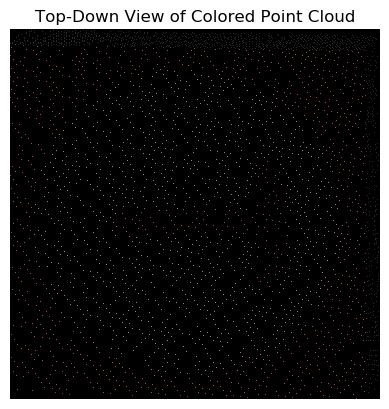

In [51]:
import matplotlib.pyplot as plt
top_view_image_color_interpolated = interpolate_sparse_image(top_view_image_color, dilation_size=(15, 15))
# 显示图像
plt.imshow(top_view_image_color)
plt.title("Top-Down View of Colored Point Cloud")
plt.axis("off")
plt.show()


In [52]:
import numpy as np

def max_downsample_image(image, pool_size=(2, 2)):
    """
    使用最大值池化对图像进行降采样。

    Args:
        image (numpy.ndarray): 输入彩色图像 (height, width, 3)
        pool_size (tuple): 池化窗口大小 (height, width)

    Returns:
        downsampled_image (numpy.ndarray): 降采样后的图像
    """
    h, w, c = image.shape
    ph, pw = pool_size

    # 确保图像尺寸是池化窗口的整数倍
    h_new = h // ph * ph
    w_new = w // pw * pw
    image_cropped = image[:h_new, :w_new, :]

    # 使用最大池化降采样
    downsampled_image = image_cropped.reshape(h_new // ph, ph, w_new // pw, pw, c).max(axis=(1, 3))

    return downsampled_image

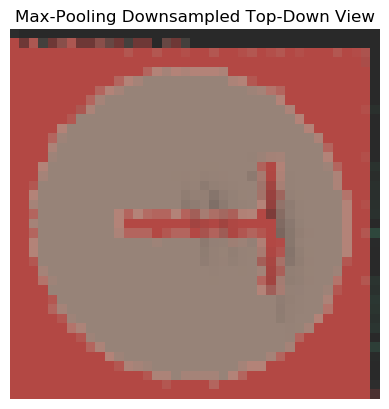

<Figure size 640x480 with 0 Axes>

In [55]:
# 使用最大值池化进行降采样
downsampled_image_max = max_downsample_image(top_view_image_color, pool_size=(13, 13))

# 显示降采样后的图像
plt.imshow(downsampled_image_max)
plt.title("Max-Pooling Downsampled Top-Down View")
plt.axis("off")
plt.show()
plt.savefig("test.png")

In [56]:
from PIL import Image
# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint8 = (downsampled_image_max * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint8)

# 保存图像为 test.png
image_to_save.save("test.png")

In [52]:
import matplotlib.pyplot as plt


In [39]:
from PIL import Image

deleted_pointcloud_transformed2 = copy.deepcopy(deleted_pointcloud2)
transformer_inv2 = np.linalg.inv(transform2)
deleted_pointcloud_transformed2.transform(transformer_inv2)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(np.pi)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed2.transform(rotation_matrix_y)
o3d.visualization.draw_geometries([deleted_pointcloud2, deleted_pointcloud_transformed2, coordinate_frame],
                                  window_name="Aligned Point Clouds")
# 生成正上方的彩色 2D 图像
top_view_image_color2 = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed2)
downsampled_image_max2 = max_downsample_image(top_view_image_color2, pool_size=(13, 13))

from PIL import Image
# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint82 = (downsampled_image_max2 * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint82)

# 保存图像为 test.png
image_to_save.save("test2.png")

0.0195010724823859 0.023692413926928668


In [40]:
from PIL import Image

deleted_pointcloud_transformed2 = copy.deepcopy(deleted_pointcloud2)
transformer_inv2 = np.linalg.inv(transform2)
deleted_pointcloud_transformed2.transform(transformer_inv2)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(np.pi)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed2.transform(rotation_matrix_y)
o3d.visualization.draw_geometries([deleted_pointcloud2, deleted_pointcloud_transformed2, coordinate_frame],
                                  window_name="Aligned Point Clouds")
# 生成正上方的彩色 2D 图像
top_view_image_color2 = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed2)
downsampled_image_max2 = max_downsample_image(top_view_image_color2, pool_size=(13, 13))

from PIL import Image
# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint82 = (downsampled_image_max2 * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint82)

# 保存图像为 test.png
image_to_save.save("test2.png")

0.0195010724823859 0.023692413926928668


0.022301313928595357 0.02463805191668711


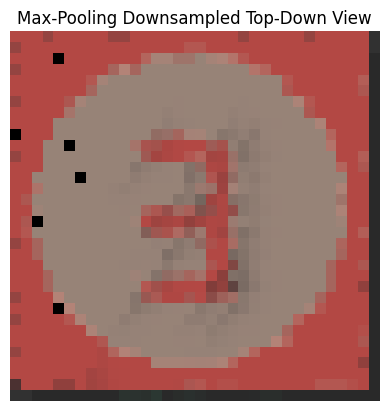

<Figure size 640x480 with 0 Axes>

In [62]:
from PIL import Image

deleted_pointcloud_transformed3 = copy.deepcopy(deleted_pointcloud3)
transformer_inv3 = np.linalg.inv(transform3)
deleted_pointcloud_transformed3.transform(transformer_inv3)
# 生成 Y 轴旋转矩阵（π弧度）
rotation_matrix_y = create_rotation_matrix_y(-np.pi/2)

# 在 transformed 点云上再应用 Y 轴旋转
deleted_pointcloud_transformed3.transform(rotation_matrix_y)
o3d.visualization.draw_geometries([deleted_pointcloud_transformed3, coordinate_frame],
                                  window_name="Aligned Point Clouds")
# 生成正上方的彩色 2D 图像
top_view_image_color3 = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed3)
downsampled_image_max3 = max_downsample_image(top_view_image_color3, pool_size=(15, 15))

plt.imshow(downsampled_image_max3)
plt.title("Max-Pooling Downsampled Top-Down View")
plt.axis("off")
plt.show()
plt.savefig("test.png")

# 将数组转换为 0-255 范围的整数值以适应 PNG 格式
downsampled_image_uint83 = (downsampled_image_max3 * 255).astype(np.uint8)

# 创建 PIL 图像对象
image_to_save = Image.fromarray(downsampled_image_uint83)

# 保存图像为 test.png
image_to_save.save("test2.png")

# 尝试使用LLM，废弃

In [24]:
with open("test3.png", "rb") as image_file:
    image_base64 = base64.b64encode(image_file.read()).decode("utf-8")


NameError: name 'base64' is not defined

In [234]:
import requests
import base64

# 定义主机地址和端口
host = "192.168.3.111"
port = "11434"
url = f"http://{host}:{port}"
model = "llava:7b"

prompt = """请根据图片内容完成以下JSON数组，并仅返回该数组，禁止任何解释或额外描述。请严格按照以下要求填写： 
{
  "text_color": 从 "Blue", "Green", "Yellow", "Red", "Wood" 中选择一个最接近的颜色作为值，
  "has_circle": 布尔值 true 或 false，表示背景颜色和字母颜色是否一致，
  "text_content": 仅包含图片中的一个字母，不可为空或包含其他内容。
}
请确保回答格式与示例完全一致。
"""

In [239]:
from ollama import Client
client = Client(
  host=url,
  headers={'x-some-header': 'some-value'}
)
response = client.chat(model=model, messages=[
  {
    'role': 'user',
    'content': prompt,
    'images': [image_base64]
  },
])
response

ChatResponse(model='llava:7b', created_at='2024-11-29T18:27:06.671301024Z', done=True, done_reason='stop', total_duration=2284509178, load_duration=3455427, prompt_eval_count=1, prompt_eval_duration=1254644000, eval_count=40, eval_duration=968752000, message=Message(role='assistant', content=' ```json\n{\n  "text_color": "Blue",\n  "has_circle": false,\n  "text_content": "R"\n}\n``` ', images=None, tool_calls=None))

In [240]:
message_content = response["message"]["content"]
message_content

' ```json\n{\n  "text_color": "Blue",\n  "has_circle": false,\n  "text_content": "R"\n}\n``` '

In [241]:
import re

# 使用正则表达式提取 JSON 数据块
cleaned_json_match = re.search(r"```json\s*(\{.*?\})\s*```", message_content, re.DOTALL)
cleaned_json_match.group(1)


'{\n  "text_color": "Blue",\n  "has_circle": false,\n  "text_content": "R"\n}'

In [232]:
parsed_json = json.loads(cleaned_json_match.group(1))
parsed_json

{'text_color': 'Red', 'has_circle': True, 'text_content': 'T'}

In [223]:
def getCubeInformationFromLLAVA(img_path, host="192.168.3.111", ):
    

SyntaxError: incomplete input (162203901.py, line 2)

# 将上面代码抽象为一个Function

In [2]:
import open3d as o3d
import numpy as np
import copy
import random

def point_cloud_perception(pointcloud, mesh_path="mesh/cube_0.obj", voxel_size=0.01, z_threshold=-0.001, debug_show=False):
    """
    点云感知功能，将输入点云与网格对齐，迭代提取所有匹配结果，直到无法继续配准。
    
    Args:
        pointcloud (open3d.geometry.PointCloud): 输入的点云对象。
        mesh_path (str): 网格文件路径。
        voxel_size (float): 体素化大小，用于特征提取。
        z_threshold (float): z 轴过滤阈值，小于该值的点将被移除。
        debug_show (bool): 是否显示调试可视化。
    
    Returns:
        list: 包含所有的变换矩阵和删除的点云对象的列表。
    """
    # 读取并处理网格
    cube_mesh = o3d.io.read_triangle_mesh(mesh_path)
    cube_mesh.compute_vertex_normals()
    mesh_pointcloud = cube_mesh.sample_points_uniformly(number_of_points=1000)

    # 过滤输入点云
    points = np.asarray(pointcloud.points)
    filtered_points = points[points[:, 2] >= z_threshold]
    filtered_pointcloud = o3d.geometry.PointCloud()
    filtered_pointcloud.points = o3d.utility.Vector3dVector(filtered_points)
    if pointcloud.has_colors():
        colors = np.asarray(pointcloud.colors)
        filtered_colors = colors[points[:, 2] >= z_threshold]
        filtered_pointcloud.colors = o3d.utility.Vector3dVector(filtered_colors)

    def preprocess_point_cloud(pcd, voxel_size):
        pcd_down = pcd.voxel_down_sample(voxel_size)
        pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))
        pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd_down,
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=100))
        return pcd_down, pcd_fpfh

    def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size, random_seed=None):
        distance_threshold = voxel_size * 1.5
        if random_seed:
            random.seed(random_seed)
        result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, True,
            distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            4,
            [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
             o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 400))
        return result

    def refine_registration(source, target, initial_transformation, voxel_size):
        distance_threshold = voxel_size * 1
        result = o3d.pipelines.registration.registration_icp(
            source, target, distance_threshold, initial_transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000)
        )
        return result

    # 初始化变量
    remaining_pointcloud = filtered_pointcloud
    results = []

    while True:
        # 下采样点云并计算特征
        source_down, source_fpfh = preprocess_point_cloud(mesh_pointcloud, voxel_size)
        target_down, target_fpfh = preprocess_point_cloud(remaining_pointcloud, voxel_size)

        # 粗配准
        random_seed = random.randint(0, 10000)  # 引入随机种子
        coarse_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size, random_seed)
        if not coarse_result or coarse_result.transformation is None:
            if debug_show:
                print("Coarse registration failed. Stopping.")
            break  # 配准失败，停止迭代

        # 精配准
        refined_result = refine_registration(mesh_pointcloud, remaining_pointcloud, coarse_result.transformation, voxel_size)

        # 检查匹配度
        fitness = refined_result.fitness
        if debug_show:
            print(f"Refined fitness: {fitness:.2%}")

        if fitness < 0.65:
            if debug_show:
                print("Fitness below 65%. Skipping this match.")
            continue  # 匹配度太低，重新尝试配准

        # 获取变换矩阵
        transform = refined_result.transformation

        # 变换网格点云到目标点云的空间
        transformed_mesh_pointcloud = copy.deepcopy(mesh_pointcloud).transform(transform)

        # 创建包围盒裁剪目标点云
        bounding_box = transformed_mesh_pointcloud.get_axis_aligned_bounding_box()
        indices_inside_box = bounding_box.get_point_indices_within_bounding_box(remaining_pointcloud.points)
        indices_outside_box = [i for i in range(len(remaining_pointcloud.points)) if i not in indices_inside_box]
        remaining_pointcloud = remaining_pointcloud.select_by_index(indices_outside_box)
        deleted_pointcloud = remaining_pointcloud.select_by_index(indices_inside_box)

        # 保存当前匹配结果
        results.append((transform, deleted_pointcloud))

        # 调试可视化
        if debug_show:
            coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
            o3d.visualization.draw_geometries(
                [mesh_pointcloud, transformed_mesh_pointcloud, remaining_pointcloud, coordinate_frame],
                window_name="Aligned Point Clouds"
            )

        # 如果剩余点云为空，停止
        if len(remaining_pointcloud.points) == 0:
            break

    return results


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
zed_point_cloud = o3d.io.read_point_cloud("mesh/zed_point_cloud_world3.ply")
results = point_cloud_perception(zed_point_cloud, debug_show=True)
transform, deleted_pointcloud = results

Refined fitness: 72.50%
Refined fitness: 65.30%
Refined fitness: 72.50%
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 0.00%
Fitness below 65%. Skipping this match.
Refined fitness: 72.00%
Refined fitness: 53.60%
Fitness below 65%. Skipping this match.
Refined fitness: 71.90%
Refined fitness: 72.20%
Refined fitness: 27.80%
Fitness below 65%. Skipping this match.
Refined fitness: 27.80%
Fitness below 65%. Skipping this match.
Refined fitness: 27.80%
Fitness below 65%. Skipping this match.
Refined fitness: 27.80%
Fitness below 65%. Skipping this match.
Refined fitness: 27.80%
Fitness below 65%. Skipping this match.
Refined fitness: 27.80%
Fitness

KeyboardInterrupt: 

# 4 上面代码有问题，尝试识别一个拿一个

In [1]:
import numpy as np
import random
import copy
import open3d as o3d

def point_cloud_perception(pointcloud, mesh_path="mesh/cube_0.obj", voxel_size=0.01, z_threshold=-0.001, debug_show=False):
    """
    点云感知功能，将输入点云与网格对齐，找到第一组匹配且匹配度高于 70% 时立即返回。
    """
    # 读取并处理网格
    cube_mesh = o3d.io.read_triangle_mesh(mesh_path)
    cube_mesh.compute_vertex_normals()
    mesh_pointcloud = cube_mesh.sample_points_uniformly(number_of_points=1000)

    # 过滤输入点云
    points = np.asarray(pointcloud.points)
    filtered_points = points[points[:, 2] >= z_threshold]
    filtered_pointcloud = o3d.geometry.PointCloud()
    filtered_pointcloud.points = o3d.utility.Vector3dVector(filtered_points)
    if pointcloud.has_colors():
        colors = np.asarray(pointcloud.colors)
        filtered_colors = colors[points[:, 2] >= z_threshold]
        filtered_pointcloud.colors = o3d.utility.Vector3dVector(filtered_colors)

    def preprocess_point_cloud(pcd, voxel_size):
        pcd_down = pcd.voxel_down_sample(voxel_size)
        pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
        pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd_down,
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))
        return pcd_down, pcd_fpfh

    def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size, random_seed=None):
        distance_threshold = voxel_size * 1.5
        if random_seed:
            random.seed(random_seed)
        result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, True,
            distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            4,
            [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
             o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 400))
        return result

    def refine_registration(source, target, initial_transformation, voxel_size):
        distance_threshold = voxel_size * 1
        result = o3d.pipelines.registration.registration_icp(
            source, target, distance_threshold, initial_transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000)
        )
        return result

    # 初始化变量
    remaining_pointcloud = filtered_pointcloud
    tried_transforms = []  # 用于记录已尝试的变换

    while True:
        # 下采样点云并计算特征
        source_down, source_fpfh = preprocess_point_cloud(mesh_pointcloud, voxel_size)
        target_down, target_fpfh = preprocess_point_cloud(remaining_pointcloud, voxel_size)

        # 粗配准
        random_seed = random.randint(0, 10000)  # 引入随机种子
        coarse_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size, random_seed)
        if not coarse_result or coarse_result.transformation is None:
            if debug_show:
                print("Coarse registration failed. Stopping.")
            break  # 配准失败，停止迭代

        # 检查是否与已有的变换过于相似
        new_transform = coarse_result.transformation
        if any(np.allclose(new_transform, tried, atol=1e-4) for tried in tried_transforms):
            if debug_show:
                print("Transform too similar to a previously tried one. Skipping.")
            continue  # 跳过相似的变换

        # 将新变换记录
        tried_transforms.append(new_transform)

        # 精配准
        refined_result = refine_registration(mesh_pointcloud, remaining_pointcloud, new_transform, voxel_size)

        # 检查匹配度
        fitness = refined_result.fitness
        if debug_show:
            print(f"Refined fitness: {fitness:.2%}")

        if fitness >= 0.7:
            # 获取变换矩阵
            transform = refined_result.transformation

            # 变换网格点云到目标点云的空间
            transformed_mesh_pointcloud = copy.deepcopy(mesh_pointcloud).transform(transform)

            # 创建包围盒裁剪目标点云
            bounding_box = transformed_mesh_pointcloud.get_axis_aligned_bounding_box()
            indices_inside_box = bounding_box.get_point_indices_within_bounding_box(remaining_pointcloud.points)
            deleted_pointcloud = remaining_pointcloud.select_by_index(indices_inside_box)

            # 调试可视化
            if debug_show:
                coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
                o3d.visualization.draw_geometries(
                    [mesh_pointcloud, transformed_mesh_pointcloud, remaining_pointcloud, coordinate_frame],
                    window_name="Aligned Point Clouds"
                )

            # 返回第一个符合条件的结果
            return transform, deleted_pointcloud
        else:
            if debug_show:
                print("Fitness below 70%. Skipping this match.")

    return None


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
def get_six_faces_pictures(deleted_pointcloud, transform):
    """
    根据输入点云生成六个面的图像：正前方、正后方、正左方、正右方、正上方和正下方。

    Args:
        deleted_pointcloud (o3d.geometry.PointCloud): 输入点云
        transform (np.ndarray): 输入的 4x4 变换矩阵
    
    Returns:
        images (dict): 六个视图的 2D 图像，以字典形式返回
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    import copy

    def pointcloud_to_top_view_image_color(pointcloud, voxel_size=0.01, output_image_size=(512, 512), depth_threshold=None):
        """
        从点云生成正上方的彩色 2D 图像，并设置深度阈值。

        Args:
            pointcloud (o3d.geometry.PointCloud): 输入点云。
            voxel_size (float): 分辨率，用于划分网格。
            output_image_size (tuple): 输出图像大小 (width, height)。
            depth_threshold (float, optional): 深度阈值，超过该深度的点将被忽略。

        Returns:
            top_view_image (numpy.ndarray): 生成的 2D 彩色图像。
        """
        points = np.asarray(pointcloud.points)
        colors = np.asarray(pointcloud.colors) if pointcloud.has_colors() else np.zeros_like(points)

        # 设置深度过滤
        if depth_threshold is not None:
            mask = points[:, 2] <= depth_threshold
            points = points[mask]
            colors = colors[mask]

        # 提取 x-y 范围
        x_min, y_min = np.min(points[:, :2], axis=0)
        x_max, y_max = np.max(points[:, :2], axis=0)

        width, height = output_image_size
        grid_x = np.linspace(x_min, x_max, width)
        grid_y = np.linspace(y_min, y_max, height)

        # 初始化 2D 彩色图像
        top_view_image = np.zeros((height, width, 3))  # RGB 图像
        count_matrix = np.zeros((height, width))

        for point, color in zip(points, colors):
            x, y, z = point
            x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
            y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
            top_view_image[height - 1 - y_idx, x_idx] += color
            count_matrix[height - 1 - y_idx, x_idx] += 1

        # 平均化颜色值
        nonzero_mask = count_matrix > 0
        top_view_image[nonzero_mask] /= count_matrix[nonzero_mask, None]
        top_view_image = np.clip(top_view_image, 0, 1)

        return top_view_image


    def max_downsample_image(image, pool_size=(2, 2)):
        """
        使用最大值池化对图像进行降采样。
        """
        h, w, c = image.shape
        ph, pw = pool_size

        h_new = h // ph * ph
        w_new = w // pw * pw
        image_cropped = image[:h_new, :w_new, :]

        downsampled_image = image_cropped.reshape(h_new // ph, ph, w_new // pw, pw, c).max(axis=(1, 3))
        return downsampled_image

    # 定义六个方向的旋转矩阵
    views = {
        "top": np.eye(4),  # 正上方，无需旋转
        "bottom": np.array([[1, 0, 0, 0],
                            [0, -1, 0, 0],
                            [0, 0, -1, 0],
                            [0, 0, 0, 1]]),  # 正下方
        "front": np.array([[1, 0, 0, 0],
                           [0, 0, -1, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 1]]),  # 正前方
        "back": np.array([[-1, 0, 0, 0],
                          [0, 0, -1, 0],
                          [0, -1, 0, 0],
                          [0, 0, 0, 1]]),  # 正后方
        "left": np.array([[0, 0, -1, 0],
                          [-1, 0, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, 0, 1]]),  # 正左方
        "right": np.array([[0, 0, 1, 0],
                           [1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 1]])   # 正右方
    }

    images = {}

    for view_name, rotation in views.items():
        # 深拷贝点云
        deleted_pointcloud_transformed = copy.deepcopy(deleted_pointcloud)

        # 矫正变换矩阵，应用当前视图旋转
        corrected_transform = np.dot(transform, rotation)

        # 将点云反变换
        transformer_inv = np.linalg.inv(corrected_transform)
        deleted_pointcloud_transformed.transform(transformer_inv)

        # 生成彩色 2D 图像
        view_image_color = pointcloud_to_top_view_image_color(deleted_pointcloud_transformed, depth_threshold=0.015)

        # 使用最大值池化降采样
        downsampled_image_max = max_downsample_image(view_image_color, pool_size=(13, 13))

        # 将图像保存为 PIL 图像
        downsampled_image_uint8 = (downsampled_image_max * 255).astype(np.uint8)
        img = Image.fromarray(downsampled_image_uint8)

        # 保存到字典
        images[view_name] = img

    return images


In [ ]:
import matplotlib.pyplot as plt
# 示例调用
zed_point_cloud = o3d.io.read_point_cloud("mesh/zed_point_cloud_world3.ply")
transform, deleted_pointcloud = point_cloud_perception(zed_point_cloud, debug_show=False)

# 调用函数生成六个方向的图像
images = get_six_faces_pictures(deleted_pointcloud, transform)

# 显示结果
for view_name, img in images.items():
    plt.figure()  # 创建新图
    plt.imshow(img)  # 显示图像
    plt.title(f"{view_name.capitalize()} View")  # 设置标题
    plt.axis("off")  # 关闭坐标轴
    plt.show()  # 在 Jupyter Lab 中显示图像


In [25]:

def keep_z_axis_only(transform):
    """
    保留变换矩阵中的 Z 轴方向变化，其余方向基于正交化调整。

    Args:
        transform (np.ndarray): 输入的 4x4 仿射变换矩阵。
    
    Returns:
        np.ndarray: 修正后的 4x4 仿射变换矩阵，只保留 Z 轴的变化。
    """
    # 复制输入矩阵以保留原始内容
    corrected_transform = np.copy(transform)

    # 提取 Z 轴方向
    z_axis = transform[:3, 2]
    z_axis = z_axis / np.linalg.norm(z_axis)  # 归一化

    # 构造一个新的 X 轴，尽量正交于 Z 轴
    arbitrary_vector = np.array([1, 0, 0]) if abs(z_axis[0]) < 0.9 else np.array([0, 1, 0])
    x_axis = np.cross(arbitrary_vector, z_axis)
    x_axis = x_axis / np.linalg.norm(x_axis)

    # 构造 Y 轴，使其与 X 和 Z 轴正交
    y_axis = np.cross(z_axis, x_axis)
    y_axis = y_axis / np.linalg.norm(y_axis)

    # 替换旋转矩阵部分
    corrected_transform[:3, 0] = x_axis
    corrected_transform[:3, 1] = y_axis
    corrected_transform[:3, 2] = z_axis

    # 保留原始的平移部分
    corrected_transform[:3, 3] = transform[:3, 3]

    return corrected_transform
transform2 = keep_z_axis_only(transform)

In [26]:
import numpy as np
cube_point_cloud_transormed = copy.deepcopy(deleted_pointcloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(np.linalg.inv(transform2))
o3d.visualization.draw_geometries([cube_point_cloud_transormed, coordinate_frame],
                                  window_name="Aligned Point Clouds")

In [27]:
transform2

array([[ 0.03779611, -0.08393224,  0.9957544 ,  0.36707326],
       [ 0.        ,  0.99646641,  0.08399225,  0.22411358],
       [-0.99928547, -0.00317458,  0.03766255,  0.01968688],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])